In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Importing necessary libraries

In [29]:
import os
from tqdm import tqdm

# Data Processing Libraries 

import pandas as pd 
import numpy as np 


# Feature Engineering Libraries

from sklearn.preprocessing import OneHotEncoder

# Data Visualisation libraries 
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")

## Image Augmentation 

# skimage
from skimage.io import imshow, imread, imsave
from skimage.transform import rotate, AffineTransform, warp,rescale, resize, downscale_local_mean
from skimage import color,data
from skimage.exposure import adjust_gamma
from skimage.util import random_noise


# 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors


#OpenCV-Python
import cv2

# imgaug
import imageio
import imgaug as ia
import imgaug.augmenters as iaa

# Albumentations
import albumentations as A

SAMPLE_LEN=100

Preparing the ground

In [30]:
train_image_path = '../input/plant-pathology-2021-fgvc8/train_images'
test_image_path = '../input/plant-pathology-2021-fgvc8/test_images'
train_df_path = '../input/plant-pathology-2021-fgvc8/train.csv'
test_df_path = '../input/plant-pathology-2021-fgvc8/sample_submission.csv'

In [31]:
df_train = pd.read_csv(train_df_path)


In [32]:
df_train.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


In [33]:
df_train['labels'].value_counts()


scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

<AxesSubplot:xlabel='labels', ylabel='Count'>

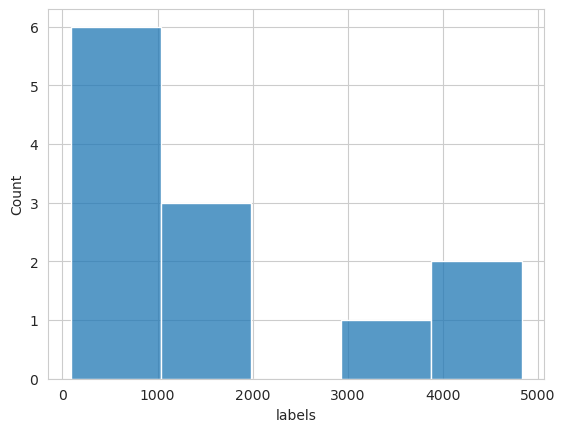

In [34]:
sns.histplot(df_train['labels'].value_counts(sort=True))


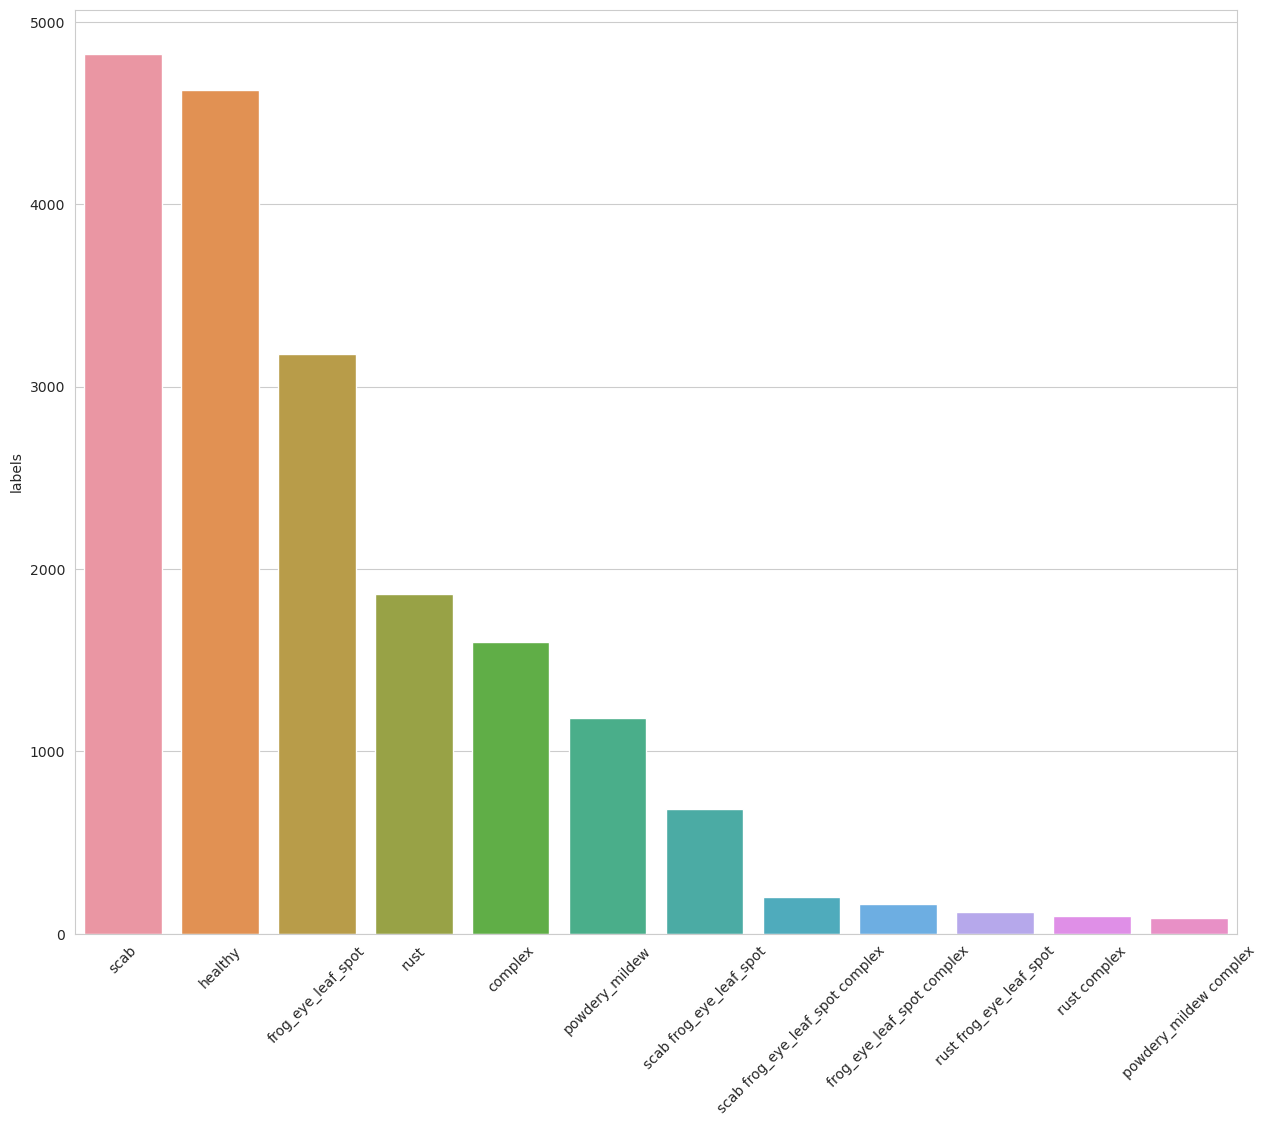

In [35]:
plt.figure(figsize=(15,12))
sns.set_style("whitegrid")
labels = sns.barplot(x=df_train.labels.value_counts().index, y=df_train.labels.value_counts())
for item in labels.get_xticklabels():
    item.set_rotation(45)
plt.show()

In [36]:
source = df_train['labels'].value_counts()


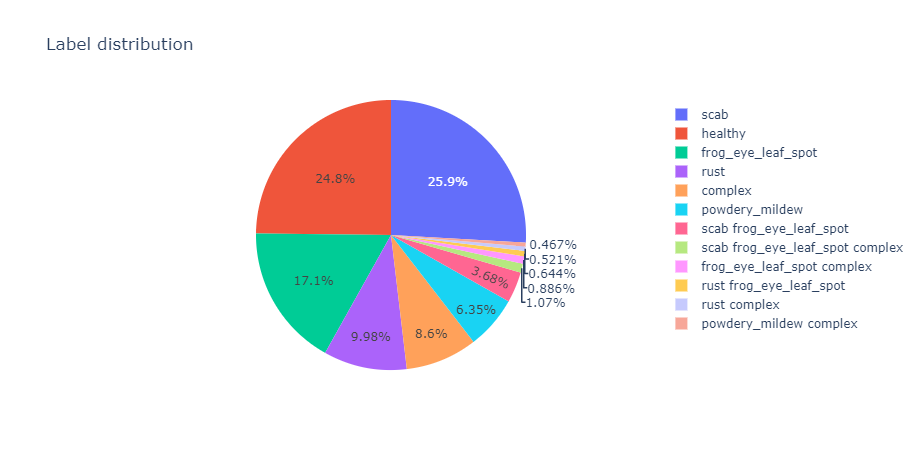

In [37]:
fig = go.Figure(data=[go.Pie(labels=source.index,values=source.values)])
fig.update_layout(title='Label distribution')
fig.show()

Dataset is pretty unbalanced as per above pie chart

In [38]:
df_train

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
...,...,...
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot


We can see that each image can have multiple labels so lets check what is the mos common label count...

The target classes, a space delimited list of all diseases found in the image. Unhealthy leaves with too many diseases to classify visually will have the complex class, and may also have a subset of the diseases identified.

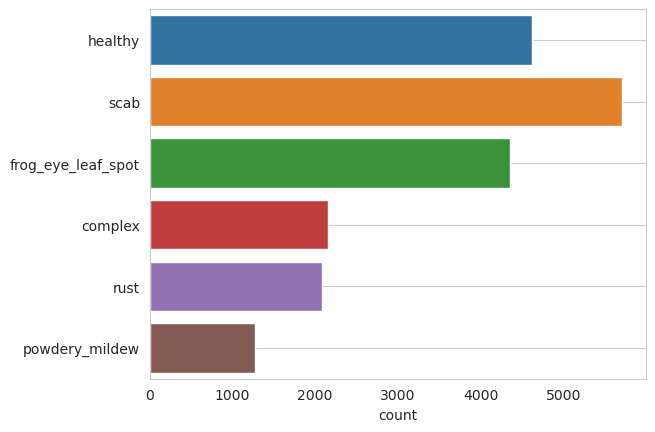

In [39]:
import itertools
import seaborn as sns

labels_all = list(itertools.chain(*[lbs.split(" ") for lbs in df_train['labels']]))
df_train['labels_sorted'] = [" ".join(sorted(lbs.split(" "))) for lbs in df_train['labels']]

ax = sns.countplot(y=labels_all, orient='v')
ax.grid()

Let see the Plant pathology Images

In [40]:
def visualize_batch(path,image_ids, labels):
    plt.figure(figsize=(16, 12))
    
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind + 1)
        image = cv2.imread(os.path.join(path, image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        plt.axis("off")
    plt.show()

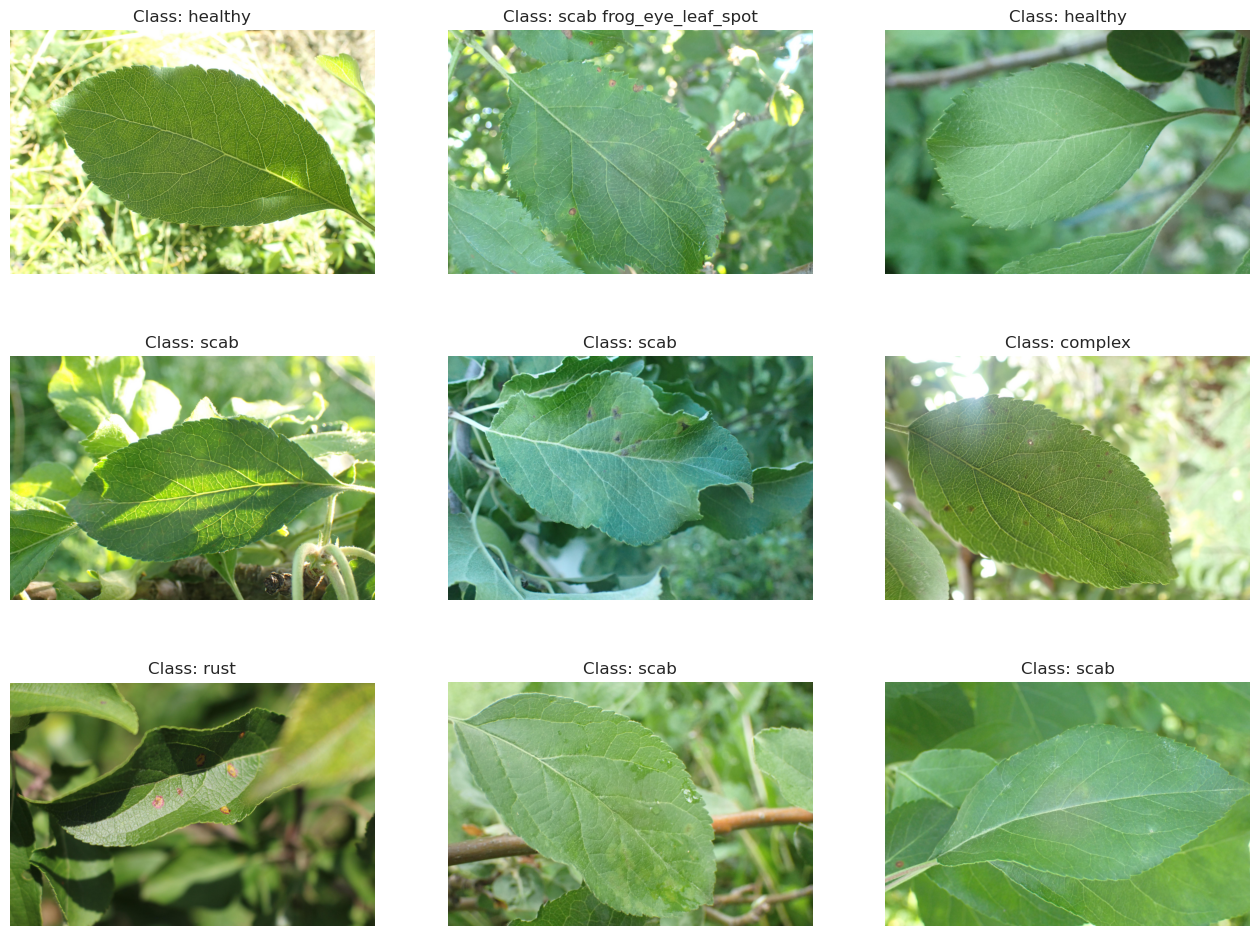

In [41]:
tmp_df = df_train.sample(9)
image_ids = tmp_df["image"].values
labels = tmp_df["labels"].values
visualize_batch(train_image_path,image_ids,labels)

In [26]:
# import pandas as pd
# import plotly.express as px



# # Create a new column "Healthy" based on the "labels" column
# df_train["Healthy"] = df_train["labels"] == "healthy"

# # Convert the "Healthy" column to boolean and then to string
# df_train["Healthy"] = df_train["Healthy"].apply(bool).apply(str)

# # Create the histogram plot
# fig = px.histogram(df_train, x="Healthy", title="Healthy Distribution", color="Healthy",\
#             color_discrete_map={
#                 "True": px.colors.qualitative.Plotly[0],
#                 "False": px.colors.qualitative.Plotly[1]})
# fig.update_layout(template="simple_white")
# fig.data[0].marker.line.color = 'rgb(0, 0, 0)'
# fig.data[0].marker.line.width = 0.5
# fig.data[1].marker.line.color = 'rgb(0, 0, 0)'
# fig.data[1].marker.line.width = 0.5
# fig.show()
